In [1]:
!pip3 install install numpy scikit-learn matplotlib seaborn

In [68]:
from typing import Tuple
import numpy as np
from numpy import ndarray
from sklearn.utils import shuffle

from sklearn.base import BaseEstimator, ClassifierMixin


class LogisticRegression(ClassifierMixin, BaseEstimator):
    """Our Logistic Regression implemented from scratch."""
    
    def __init__(self, learning_rate : float = 0.001,
                 n_epochs : int = 1000, random_state : int = 42, alpha: float = 0.0001,optimizer="batch"):
        """
        Parameters
        ----------
        learning_rate : float, default=0.001
            Learning rate.
        n_epochs : int, default=1000
            Number of epochs for training (convergence stop).
        random_state : int, default="batch"
            Seed used for generating random numbers.
        optimizer : string, default=42
            Gradient implementation - batch, mini or stochastic
        """
        assert (learning_rate is not None) and (learning_rate > 0.0), \
        f'Learning rate must be > 0. Passed: {learning_rate}'
        
        assert (n_epochs is not None) and (n_epochs > 0), \
        f'Number of epochs must be > 0. Passed: {n_epochs}'
        
        # public ==> todo mundo tem acesso para leitura e escrita direta
        # private ==> apenas a classe tem acesso para leitura e escrita direta
        self.learning_rate = learning_rate
        self.n_epochs = n_epochs
        self.random_state = random_state
        self.optimizer = optimizer
        self.alpha = alpha
        
        # parameters to be trained/learned
        self.__w = []  # weight array
        self.__b = []  # bias
        self.__loss= [] # cost function values
        self.__y= [] # cost function values

    
    
    # a special method used to represent a class object as a string, called with print() or str()
    def __str__(self):
        msg = f'Learning rate: {self.learning_rate}\n' \
              f'Number of epochs: {self.n_epochs}\n' \
              f'Random state: {self.random_state}\n' \
              f'Optimizer: {self.optimizer}\n' \
              f'Trained?: {self.is_fitted()}'
        return msg
    
    
    # getter: access the function as an attribute - it is not possible to set values through it
    @property
    def coef_(self) -> ndarray:
        """Return the weight matrix (learned parameters) if the estimator was fitted/trained.
           Otherwise, raise an exception.
        """
        assert self.is_fitted(), 'The instance is not fitted yet.'
        return self.__w
    
    
    # getter: access the function as an attribute - it is not possible to set values through it
    @property
    def intercept_(self) -> float:
        """Return the bias (learned intercepet) if the estimator was fitted/trained.
           Otherwise, raise an exception.
        """
        assert self.is_fitted(), 'The instance is not fitted yet.'
        return self.__b
    
    
    def is_fitted(self) -> bool:
        return self.__w is not None
    
    
    def __sigmoid(self, z: ndarray) -> ndarray:
        return 1 / (1 + np.e ** (-z))
    
    
    def __log_loss(self, y: ndarray, p_hat: ndarray, eps: float = 1e-15):
        '''Return the log loss for a given estimation and ground-truth (true labels).
        
        log is undefined for 0. Consequently, the log loss is undefined for `p_hat=0` (because of log(p_hat)) and `p_hat=1` (because of ln(1 - p_hat)).
        To overcome that, we clipped the probabilities to max(eps, min(1 - eps, p_hat)), where `eps` is a tiny constant. 

        
        Parameters
        ----------
        y : ndarray, shape (n_samples,)
            True labels of input samples.
        p_hat : ndarray
            Estimated probabilities of input samples.
        eps : float, default=1e-15
            Epsilon term used to avoid undefined log loss at 0 and 1.
        
        Returns
        -------
        log_loss : float
            Computed log loss.
        '''
        
        p_hat_eps = np.maximum(eps, np.minimum(1 - eps, p_hat))
        
        # shape: (n_samples,)
        losses = -(y * np.log(p_hat_eps) + (1 - y) * np.log(1 - p_hat_eps))
        log_loss = losses.mean()
        
        return log_loss
    
    
    def __gradient(self, X: ndarray, y: ndarray, p_hat: ndarray, w: ndarray) -> Tuple[ndarray, float]:
        '''Compute the gradient vector for the log loss with regards to the weights and bias.
        
        Parameters
        ----------
        X: ndarray of shape (n_samples, n_features)
            Training data.
        y: ndarray of shape (n_samples,).
            Target (true) labels.
        p_hat : ndarray, shape (n_samples,)
            Estimated probabilities.
        w : ndarray, shape (n_features,)
            Weight array.
        alpha : float
            Reguralization constant.
        
        Returns
        -------
        Tuple[ndarray, float]: 
            Tuple with:
            - a numpy array of shape (n_features,) containing the partial derivatives w.r.t. the weights; and
            - a float representing the partial derivative w.r.t. the bias.
        '''
        # X.shape: (n_samples, n_features)
        # y.shape == p_hat.shape: (n_samples,)
        n_samples = X.shape[0]
        regularization = self.alpha * w
        error = p_hat - y  # shape (n_samples,)
        grad_w = np.dot(error, X) / n_samples + regularization # shape (n_features,)
        grad_b = error.mean()  # float
        
        return grad_w, grad_b


    def fit(self, X: ndarray, y: ndarray, verbose: int = 0, batch_size = 'auto'):
        '''Train a Logistic Regression classifier.

        Parameters
        ----------
        X: ndarray of shape (n_samples, n_features)
            Training data.
        y: ndarray of shape (n_samples,).
            Target (true) labels.
        verbose: int, default=0
            Verbose flag. Print training information every `verbose` iterations.
            
        Returns
        -------
        self : object
            Returns self.
        '''
        ### CHECK INPUT ARRAY DIMENSIONS
        assert X.ndim == 2, f'X must be 2D. Passed: {X.ndim}'
        assert y.ndim == 1, f'y must be 1D. Passed: {y.ndim}'
        assert X.shape[0] == y.shape[0], \
            f'X.shape[0] should be equal to y.shape[0], instead: {X.shape[0]} != {y.shape[0]}'
        # X, y = check_X_y(X, y)

        ### SETTING SEED
        np.random.seed(self.random_state)
        
        n_samples, n_features = X.shape

        # Altough the bias trick is an elegant solution to merge all
        # parameters, it requires to extend the feature matrix X
        # by adding one column of 1.0. This demands time, so we will
        # deal with the weights and bias separately.

        ### PARAMETER INITIALIZATION
        
        # return values from the “standard normal” distribution.
        

        for i in np.unique(y):
            y_onevsall = np.where(y == i, 1, 0)
            losses = []
            w = np.random.randn(n_features)
            b = 0.0
        # learning iterations
            for epoch in np.arange(self.n_epochs):
                ### ESTIMATION (FORWARD PASS)
                # X.shape == (n_samples, n_features)
                # w.shape = (n_features,)
                # p_hat = (n_samples,)
                loss=0
                
                if self.optimizer == 'batch':
                  z = np.dot(X, w) + b
                  p_hat = self.__sigmoid(z)
                  #y_hat = p_hat.astype(np.int)
                  loss = self.__log_loss(y_onevsall, p_hat)
                  losses.append(loss)
                  
                  ### GRADIENT DESCENT (BACKWARD PASS)
                  # grad_w.shape ==> (n_samples, 1)
                  # grad_b: scalar
                  grad_w, grad_b = self.__gradient(X, y_onevsall, p_hat, w)
                  w = w - self.learning_rate * grad_w
                  b = b - self.learning_rate * grad_b
                
                if self.optimizer  == "mini":
                  if batch_size == "auto":
                    batch_size= X.shape[0]/4
                  n_mini_batches = int(np.ceil(X.shape[0]/batch_size))
                  X, y_onevsall = shuffle(X, y_onevsall)
                  for i in range(n_mini_batches):
                    X_mini = X[int(i*batch_size):int((i+1)*batch_size),:]
                    y_mini = y_onevsall[int(i*batch_size):int((i+1)*batch_size)]
                    z = np.dot(X_mini, w) + b
                    p_hat_mini = self.__sigmoid(z)
                   #y_hat_mini = p_hat_mini.astype(np.int)
                    
                    loss = self.__log_loss(y_mini, p_hat_mini)
                    losses.append(loss)
                    
                    ### GRADIENT DESCENT (BACKWARD PASS)
                    # grad_w.shape ==> (n_samples, 1)
                    # grad_b: scalar
                    grad_w, grad_b = self.__gradient(X_mini, y_mini, p_hat_mini, w)
                    w = w - self.learning_rate * grad_w
                    b = b - self.learning_rate * grad_b
                    if verbose:
                      print(f'[INFO] batch={i + 1}/{n_mini_batches}')

                if self.optimizer  == "stochastic":
                  for i in range(X.shape[0]):
                    X_stochastic = X[i,:]
                    y_stochastic = y_onevsall[i]
                    z = np.dot(X_stochastic, w) + b
                    p_hat_stochastic = self.__sigmoid(z)
                    #y_hat_stochastic = p_hat_stochastic.astype(np.int)
                    
                    loss = self.__log_loss(y_stochastic, p_hat_stochastic)
                    losses.append(loss)
                    
                    ### GRADIENT DESCENT (BACKWARD PASS)
                    # grad_w.shape ==> (n_samples, 1)
                    # grad_b: scalar
                    grad_w, grad_b = self.__gradient(X_stochastic, y_stochastic, p_hat_stochastic, w )
                    w = w - self.learning_rate * grad_w
                    b = b - self.learning_rate * grad_b
                    if verbose:
                      print(f'[INFO] sample={i + 1}/{X.shape[0]}')
                
                # check to see if an update should be displayed
                if verbose and (epoch == 0 or (epoch + 1) % verbose == 0):
                    print(f'[INFO] epoch={epoch + 1}/{self.n_epochs}, loss={loss:.7f}')
            
            if verbose > 0:
                losses = np.array(losses)
                print(f'\nFinal loss: {loss}')
                print(f'\nMean loss: {losses.mean()} +- {losses.std()}')
                
            ### ASSIGN THE TRAINED PARAMETERS TO THE PRIVATE ATTRIBUTES
            self.__w.append(w)
            self.__loss.append(losses)
            self.__b.append(b)
            self.__y.append(i)

        
    
    def predict_proba(self, X: ndarray, w: ndarray, b:ndarray) -> ndarray:
        '''Estimate the probability for the positive class of input samples.

        Parameters
        ----------
        X: ndarray of shape (n_samples, n_features)
            Input samples.
            
        Returns
        -------
        ndarray of shape (n_samples,)
            The estimated probabilities for the positive class of input samples.
        '''
        assert self.is_fitted(), 'The instance is not fitted yet.'
        assert X.ndim == 2, f'X must be 2D. Passed: {X.ndim}'
        
        z = np.dot(X, w) + b

        return self.__sigmoid(z)

    
    def predict(self, X: ndarray) -> ndarray:
        '''Predict the labels for input samples.
        
        Thresholding at probability >= 0.5.

        Parameters
        ----------
        X: ndarray of shape (n_samples, n_features)
            Input samples.
            
        Returns
        -------
        ndarray of shape (n_samples,)
            Predicted labels of input samples.
        '''
        assert self.is_fitted(), 'The instance is not fitted yet.'
        assert X.ndim == 2, f'X must be 2D. Passed: {X.ndim}'
        y = []
        t = -1
        #X = np.insert(X, 0, 1, axis=1)
        X_predicted = [max(self.predict_proba(i.reshape(-1,1).reshape(1,-1),theta,c) for theta, c in zip(self.__w, self.__b)) for i in X ]

        #return X_predicted
        for x in X:
          vec_prob = []
          for i in range(len(self.__y)):
              x = np.array(x.reshape(-1,1).reshape(1,-1), dtype="float64")
              p_hat = self.predict_proba(x, self.__w[i], self.__b[i])
              vec_prob.append(p_hat)
          y.append(vec_prob.index(max(vec_prob)))
        
        return y


In [3]:
clf = LogisticRegression()

In [4]:
from sklearn import datasets
from sklearn.model_selection import train_test_split, GridSearchCV
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 2. Manipulando os dados

In [5]:
dataset = datasets.load_wine()
dataset

{'data': array([[1.423e+01, 1.710e+00, 2.430e+00, ..., 1.040e+00, 3.920e+00,
         1.065e+03],
        [1.320e+01, 1.780e+00, 2.140e+00, ..., 1.050e+00, 3.400e+00,
         1.050e+03],
        [1.316e+01, 2.360e+00, 2.670e+00, ..., 1.030e+00, 3.170e+00,
         1.185e+03],
        ...,
        [1.327e+01, 4.280e+00, 2.260e+00, ..., 5.900e-01, 1.560e+00,
         8.350e+02],
        [1.317e+01, 2.590e+00, 2.370e+00, ..., 6.000e-01, 1.620e+00,
         8.400e+02],
        [1.413e+01, 4.100e+00, 2.740e+00, ..., 6.100e-01, 1.600e+00,
         5.600e+02]]),
 'target': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [6]:
X = dataset.data
y = dataset.target

In [7]:

df = pd.DataFrame(data=X, columns=dataset.feature_names)
df.isnull().sum()

alcohol                         0
malic_acid                      0
ash                             0
alcalinity_of_ash               0
magnesium                       0
total_phenols                   0
flavanoids                      0
nonflavanoid_phenols            0
proanthocyanins                 0
color_intensity                 0
hue                             0
od280/od315_of_diluted_wines    0
proline                         0
dtype: int64

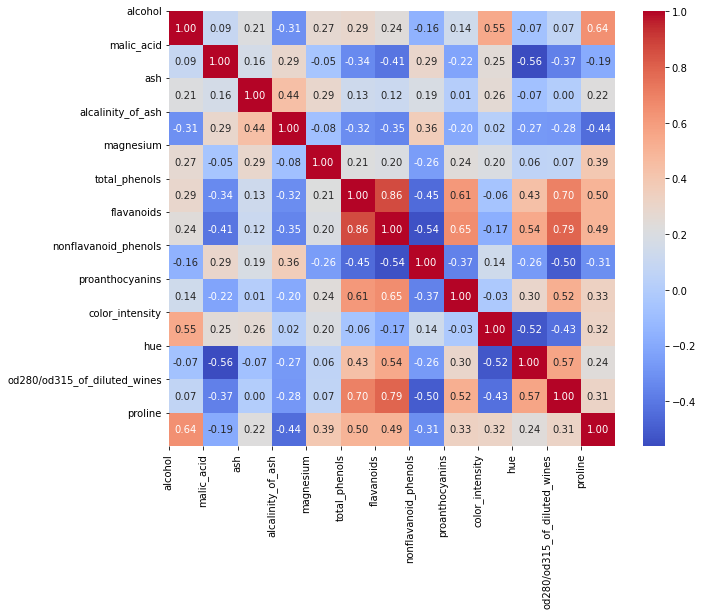

In [8]:
corr = df.corr()
#Plot figsize
fig, ax = plt.subplots(figsize=(10, 8))
#Generate Heat Map, allow annotations and place floats in map
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt=".2f")
#Apply xticks
plt.xticks(range(len(corr.columns)), corr.columns);
#Apply yticks
plt.yticks(range(len(corr.columns)), corr.columns)
#show plot
plt.show()

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [10]:
from sklearn.preprocessing import RobustScaler

scaller = RobustScaler()
X_train = scaller.fit_transform(X_train)
X_test = scaller.transform(X_test)

#X_train, X_val,y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# 3. Finetuning do nosso modelo para cada otimizador

In [11]:
params ={"optimizer" : ['mini'], "n_epochs" : [100,200,300,500,1000,2000,5000], "learning_rate" : [0.01,0.001,0.005,0.05,0.1]}

gd_mini = GridSearchCV(clf, params, cv=10, scoring='balanced_accuracy', n_jobs=6)

In [12]:
from datetime import datetime

In [13]:
dateTimeObj = datetime.now()
print("Início: ", dateTimeObj.hour, ':', dateTimeObj.minute, ':', dateTimeObj.second)

gd_mini.fit(X_train, y_train, batch_size=32)

dateTimeObj = datetime.now()
print("Fim: ", dateTimeObj.hour, ':', dateTimeObj.minute, ':', dateTimeObj.second)

Início:  14 : 9 : 5
Fim:  14 : 9 : 39


In [14]:
gd_mini.best_score_

0.7244444444444446

In [15]:
gd_mini.best_params_

{'learning_rate': 0.1, 'n_epochs': 300, 'optimizer': 'mini'}

In [16]:
params ={"optimizer" : ['batch'], "n_epochs" : [100,200,300,500,1000,2000,5000], "learning_rate" : [0.01,0.001,0.005,0.05,0.1]}

gd_batch = GridSearchCV(clf, params, cv=10, scoring='balanced_accuracy', n_jobs=6)

In [17]:
dateTimeObj = datetime.now()
print("Início: ", dateTimeObj.hour, ':', dateTimeObj.minute, ':', dateTimeObj.second)

gd_batch.fit(X_train, y_train)

dateTimeObj = datetime.now()
print("Fim: ", dateTimeObj.hour, ':', dateTimeObj.minute, ':', dateTimeObj.second)

Início:  14 : 9 : 39
Fim:  14 : 9 : 48


In [18]:
gd_batch.best_score_

0.9888888888888889

In [19]:
gd_batch.best_params_

{'learning_rate': 0.1, 'n_epochs': 5000, 'optimizer': 'batch'}

In [20]:
params ={"optimizer" : ['stochastic'], "n_epochs" : [100,200,300,500,1000,2000,5000], "learning_rate" : [0.01,0.001,0.005,0.05,0.1]}

gd_stochastic = GridSearchCV(clf, params, cv=10, scoring='balanced_accuracy', n_jobs=6)

In [21]:
dateTimeObj = datetime.now()
print("Início: ", dateTimeObj.hour, ':', dateTimeObj.minute, ':', dateTimeObj.second)

gd_stochastic.fit(X_train, y_train)

dateTimeObj = datetime.now()
print("Fim: ", dateTimeObj.hour, ':', dateTimeObj.minute, ':', dateTimeObj.second)

Início:  14 : 9 : 48
Fim:  14 : 22 : 49


In [22]:
gd_stochastic.best_params_

{'learning_rate': 0.01, 'n_epochs': 1000, 'optimizer': 'stochastic'}

In [23]:
gd_stochastic.best_score_

0.9833333333333334

In [24]:
X_train.shape

(142, 13)

# 4. Finetuning SGDClassifier e LogisticRegression do sklearn

In [25]:
from sklearn.linear_model import LogisticRegression as sklearnLR

In [26]:
lr = sklearnLR()

In [27]:
params = {"penalty":["l2","none"], "max_iter":[100,200,300,500,1000,2000,5000]}
gd_lr = GridSearchCV(lr, params, cv=10,scoring='balanced_accuracy', n_jobs=6)

In [28]:
dateTimeObj = datetime.now()
print("Início: ", dateTimeObj.hour, ':', dateTimeObj.minute, ':', dateTimeObj.second)

gd_lr.fit(X_train, y_train)

dateTimeObj = datetime.now()
print("Fim: ", dateTimeObj.hour, ':', dateTimeObj.minute, ':', dateTimeObj.second)

Início:  14 : 22 : 49
Fim:  14 : 22 : 49


In [29]:
gd_lr.best_score_

0.9805555555555555

In [30]:
gd_lr.best_params_

{'max_iter': 100, 'penalty': 'l2'}

In [31]:
from sklearn.linear_model import SGDClassifier

In [32]:
sgd = SGDClassifier()

In [33]:
params = {"loss":["hinge","squared_error","squared_hinge"],"penalty":["l1","l2","elasticnet"], "max_iter":[100,200,300,500,1000,2000,5000],"learning_rate" : ["constant", "optimal", "invscaling"], "eta0":[0.01,0.001,0.005,0.05,0.1]}
gd_sgd = GridSearchCV(sgd, params, cv=10,scoring='balanced_accuracy', n_jobs=6)

In [34]:
dateTimeObj = datetime.now()
print("Início: ", dateTimeObj.hour, ':', dateTimeObj.minute, ':', dateTimeObj.second)

gd_sgd.fit(X_train, y_train)

dateTimeObj = datetime.now()
print("Fim: ", dateTimeObj.hour, ':', dateTimeObj.minute, ':', dateTimeObj.second)

Início:  14 : 22 : 49


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteratio

/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteratio

/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteratio

/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteratio

/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteratio

/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteratio

Fim:  14 : 22 : 54


In [35]:
gd_sgd.best_params_

{'eta0': 0.01,
 'learning_rate': 'optimal',
 'loss': 'hinge',
 'max_iter': 2000,
 'penalty': 'l1'}

In [36]:
gd_sgd.best_score_

0.9944444444444445

# 5. Teste dos modelos escolhidos

* LogisticRegression - implementado com - {'learning_rate': 0.1, 'n_epochs': 300, 'optimizer': 'mini'}
* LogisticRegression - implementado com - {'learning_rate': 0.1, 'n_epochs': 5000, 'optimizer': 'batch'}
* LogisticRegression - implementado com - {'learning_rate': 0.01, 'n_epochs': 1000, 'optimizer': 'stochastic'}
* LogisticRegression - sklearn com - {'max_iter': 100, 'penalty': 'l2'}
* SGDClassifier - sklearn com - {'eta0': 0.05, 'learning_rate': 'constant', 'loss': 'squared_error', 'max_iter': 1000, 'penalty': 'l2'}

In [37]:
lr_mini = gd_mini.best_estimator_
lr_batch = gd_batch.best_estimator_
lr_sthocastic = gd_stochastic.best_estimator_
sgd = gd_sgd.best_estimator_
lr = gd_lr.best_estimator_

In [38]:
y_mini = lr_mini.predict(X_test)
y_batch = lr_batch.predict(X_test)
y_stochastic = lr_sthocastic.predict(X_test)
y_sgd = sgd.predict(X_test)
y_lr = lr.predict(X_test)

In [39]:
from sklearn.metrics import accuracy_score

In [40]:
accuracy_score(y_test, y_mini)

0.6666666666666666

In [41]:
accuracy_score(y_test, y_batch)

1.0

In [42]:
accuracy_score(y_test, y_stochastic)

1.0

In [43]:
accuracy_score(y_test, y_sgd)

1.0

In [44]:
accuracy_score(y_test, y_lr)

1.0

## Cross Validation com K-Fold

In [45]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

In [106]:
def plot_result(model_name: str, metric: str, validation_accuracy: list, cross_val_accuracy:list, labels: list, last_column_highlight: bool = False ) -> None:
        
        plt.figure(figsize=(20,6))
        X_axis = np.arange(len(labels))
        ax = plt.gca()
        plt.ylim(0.0, 1.2)
        plt.bar(X_axis-0.2, cross_val_accuracy, 0.4, color='grey', label='Training')
        
        clrs = ['red' if (i == len(validation_accuracy)-1) else 'blue' for i in range(0, len(validation_accuracy)) ] if last_column_highlight else 'red'
        plt.bar(X_axis+0.2, validation_accuracy, 0.4, color=clrs, label='Validation')            
    
        plt.title('Accuracy Plot - ' + model_name, fontsize=20)
        xlocs, xlabs = plt.xticks(X_axis, labels)
        
        xlocs=[i+1 for i in range(len(validation_accuracy))]
        for i, v in enumerate(validation_accuracy):
            plt.text(xlocs[i] - 1.075, v + 0.05, str("%.2f" % v))
            
        plt.xlabel(model_name, fontsize=14)
        plt.ylabel(metric, fontsize=14)
        plt.legend()
#         plt.grid(True)
        plt.show()

In [60]:
class KFoldTrainer():
    
    def __init__(self):
        pass
    
    @staticmethod
    def __training_mini(_learning_rate=0.1, _n_epochs=300) -> LogisticRegression:
        return LogisticRegression(learning_rate=_learning_rate, n_epochs=_n_epochs, optimizer='mini')
        
    @staticmethod
    def __training_batch(_learning_rate=0.1, _n_epochs=5000) -> LogisticRegression:
        return LogisticRegression(learning_rate=_learning_rate, n_epochs=_n_epochs, optimizer='batch')
        
    @staticmethod
    def __training_stochastic(_learning_rate=0.1, _n_epochs=1000) -> LogisticRegression:
        return LogisticRegression(learning_rate=_learning_rate, n_epochs=_n_epochs, optimizer='stochastic')
    
    @staticmethod
    def __training_sgd(_eta0=0.001, _max_iter=300):
        return SGDClassifier(eta0=_eta0, max_iter=_max_iter)
    
    @staticmethod
    def __training_sklearn_logistic_regression(_max_iter=100):
        return sklearnLR(max_iter=_max_iter)
    
    @staticmethod
    def __default() -> None:
        raise Exception('Modelo desconhecido; verifique o nome do modelo fornecido e tente novamente...')
        
    @staticmethod
    def __get_model(model):
        switch = {
            'mini': KFoldTrainer.__training_mini,
            'batch': KFoldTrainer.__training_batch,
            'stochastic': KFoldTrainer.__training_stochastic,
            'sgd': KFoldTrainer.__training_sgd,
            'sklearn_lr': KFoldTrainer.__training_sklearn_logistic_regression
        }
        
        case = switch.get(model, KFoldTrainer.default)
        return case()
    
    @staticmethod
    def get_better_estimator(trained_models: dict):
        
        best_model_index = trained_models['train_accuracy'].index(max(trained_models['train_accuracy']))
        return trained_models['trained_models'][best_model_index]
    
    @staticmethod
    def do_training(model_name, X_train, y_train, _n_splits=10, _shuffle=True, _random_state=42) -> list:
        
        kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    
        train_accuracy = []
        trained_models = []

        for train_index, test_index in kfold.split(X_train, y_train):
            model = KFoldTrainer.__get_model(model_name)
            model.fit(X_train[train_index], y_train[train_index])
            y_predict = model.predict(X_train[test_index])
            
            trained_models.append(model)
            train_accuracy.append(accuracy_score(y_train[test_index], y_predict))
                        
        return {
            'trained_models': trained_models,
            'train_accuracy': train_accuracy
        }

In [56]:
model_names = ['mini', 'batch', 'stochastic', 'sgd', 'sklearn_lr']
models = []

for model_name in model_names:
    models.append(KFoldTrainer.do_training(model_name, X_train, y_train))
    
best_models = []

for model in models:
    best_models.append(KFoldTrainer.get_better_estimator(model))

{'trained_models': [LogisticRegression(learning_rate=0.1, n_epochs=300, optimizer='mini'), LogisticRegression(learning_rate=0.1, n_epochs=300, optimizer='mini'), LogisticRegression(learning_rate=0.1, n_epochs=300, optimizer='mini'), LogisticRegression(learning_rate=0.1, n_epochs=300, optimizer='mini'), LogisticRegression(learning_rate=0.1, n_epochs=300, optimizer='mini'), LogisticRegression(learning_rate=0.1, n_epochs=300, optimizer='mini'), LogisticRegression(learning_rate=0.1, n_epochs=300, optimizer='mini'), LogisticRegression(learning_rate=0.1, n_epochs=300, optimizer='mini'), LogisticRegression(learning_rate=0.1, n_epochs=300, optimizer='mini'), LogisticRegression(learning_rate=0.1, n_epochs=300, optimizer='mini')], 'train_accuracy': [0.6, 0.5333333333333333, 0.7142857142857143, 0.5714285714285714, 0.7142857142857143, 0.5714285714285714, 0.6428571428571429, 0.7857142857142857, 0.6428571428571429, 0.6428571428571429]}
{'trained_models': [LogisticRegression(learning_rate=0.1, n_epoc

In [72]:
accuracies = []

for model in best_models:
    y_hat_train = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_hat_train)
    print(f'Model: {model}\nAccuracy: {accuracy}\n\n')
    accuracies.append(accuracy)

Model: Learning rate: 0.1
Number of epochs: 300
Random state: 42
Optimizer: mini
Trained?: True

Accuracy: 0.7222222222222222


Model: Learning rate: 0.1
Number of epochs: 5000
Random state: 42
Optimizer: batch
Trained?: True

Accuracy: 1.0


Model: Learning rate: 0.1
Number of epochs: 1000
Random state: 42
Optimizer: stochastic
Trained?: True

Accuracy: 1.0


Model: SGDClassifier(eta0=0.001, max_iter=300)
Accuracy: 1.0


Model: LogisticRegression()
Accuracy: 1.0




In [89]:
from sklearn.model_selection import cross_validate

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

lr_mini_cross_val = LogisticRegression(learning_rate=0.1, n_epochs=300, optimizer='mini')
lr_batch_cross_val = LogisticRegression(learning_rate=0.1, n_epochs=5000, optimizer='batch')
lr_stochastic_cross_val = LogisticRegression(learning_rate=0.1, n_epochs=1000, optimizer='stochastic')
sgd_cross_val = SGDClassifier(eta0=0.001, max_iter=300)
logistic_cross_val = sklearnLR(max_iter=100)

cv_results_lr_mini_cross_val = cross_validate(lr_mini_cross_val, X_train, y_train, scoring='accuracy', cv= StratifiedKFold(n_splits=10, shuffle=True, random_state=42),return_train_score=True, return_estimator=True)
cv_results_lr_batch_cross_val = cross_validate(lr_batch_cross_val, X_train, y_train, scoring='accuracy', cv= StratifiedKFold(n_splits=10, shuffle=True, random_state=42),return_train_score=True, return_estimator=True)
cv_results_lr_stochastic_cross_val= cross_validate(lr_stochastic_cross_val, X_train, y_train, scoring='accuracy', cv= StratifiedKFold(n_splits=10, shuffle=True, random_state=42),return_train_score=True, return_estimator=True)
cv_results_sgd_cross_val = cross_validate(sgd_cross_val, X_train, y_train, scoring='accuracy', cv= StratifiedKFold(n_splits=10, shuffle=True, random_state=42),return_train_score=True, return_estimator=True)
cv_results_logistic_cross_val = cross_validate(logistic_cross_val, X_train, y_train, scoring='accuracy', cv= StratifiedKFold(n_splits=10, shuffle=True, random_state=42),return_train_score=True, return_estimator=True)


In [95]:
def do_cross_val(result, X_test, y_test):
    estimators = result['estimator']
    best_model_index = result['train_score'].tolist().index(max(result['train_score']))
    best_estimator = estimators[best_model_index]
    y_hat = best_estimator.predict(X_test)
    return accuracy_score(y_test, y_hat)



cross_val_sklearn_estimators = [cv_results_lr_mini_cross_val, cv_results_lr_batch_cross_val,
                               cv_results_lr_stochastic_cross_val, cv_results_sgd_cross_val,
                               cv_results_logistic_cross_val]

cross_val_accuracy = []

for estimator in cross_val_sklearn_estimators:
    cross_val_accuracy.append(do_cross_val(estimator, X_test, y_test))

[0.75, 1.0, 1.0, 1.0, 1.0]

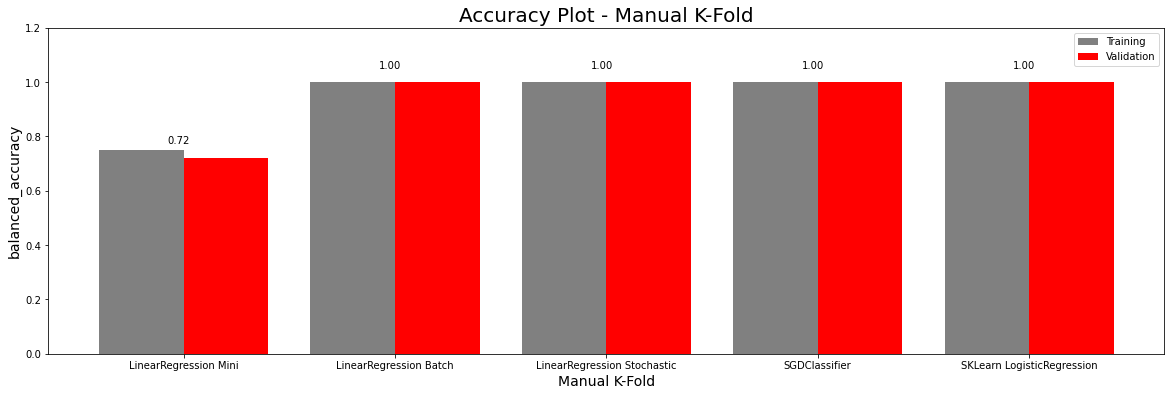

In [107]:
## Comparação dos resultados
labels = ["LinearRegression Mini", "LinearRegression Batch", "LinearRegression Stochastic",
          "SGDClassifier", "SKLearn LogisticRegression"]

results = [
    {
        'model_name': 'Manual K-Fold',
        'metric': 'balanced_accuracy',
        'validation_accuracy': accuracies,
        'cross_val_accuracy': cross_val_accuracy,
        'labels': labels,
        'last_column_highlight': False
    }
]

for model_result in results:
    plot_result(**model_result)

In [ ]:
from sklearn.model_selection import cross_validate

folds = kfold.split(X_train, y_train)
cv_results= cross_validate(lr_mini, X_train, y_train, scoring='accuracy', cv= folds,return_train_score=True, return_estimator=True)

In [ ]:
test = cv_results['estimator']
best_model_index = cv_results['train_score'].tolist().index(max(cv_results['train_score']))
best_model = test[best_model_index]
y_hat_train= best_model.predict(X_test)
accuracy_score(y_test, y_hat_train)

In [ ]:
max(lr_mini_train_accuracy)

In [ ]:
y_mini = lr_mini.predict(X_test)
y_batch = lr_batch.predict(X_test)
y_stochastic = lr_stochastic.predict(X_test)
y_sgd = gd_sgd.predict(X_test)
y_lr = sklearn_lr.predict(X_test)

lr_mini_validation_accuracy = accuracy_score(y_test, y_mini)
lr_batch_validation_accuracy = accuracy_score(y_test, y_batch)
lr_stochastic_validation_accuracy = accuracy_score(y_test, y_stochastic)
sgd_validation_accuracy = accuracy_score(y_test, y_sgd)
sklearn_lr_validation_accuracy = accuracy_score(y_test, y_lr)

In [ ]:
print(f'lr_mini_validation_accuracy: {lr_mini_validation_accuracy}')
print(f'lr_batch_validation_accuracy: {lr_batch_validation_accuracy}')
print(f'lr_stochastic_validation_accuracy: {lr_stochastic_validation_accuracy}')